# **Predicting Analytics Course Enrollees' Employment Outlook**
## [HR Analytics](https://datahack.analyticsvidhya.com/contest/janatahack-hr-analytics/#ProblemStatement) (by Analyticsvidhya)
***

# **1. Define**
******

## The problem
An analytics/ data science training institute has been successful in getting students to signup with their platform and enrolling to relevant data science or analytics courses. This training institute wants to further expand their business to manpower recruitment in data science field. The institute wants to connect the enrollees with their clients who are looking to hire employees in same domain. 

So the company wants to understand the factors that lead a person to look for a job change and predict if a candidate is looking for a new employment from student information related to demographics, education, experience and training course enrollement features.

Expanding to a new business can potentially generate huge revenue for this already growing company. People generally enroll in these type of training courses in data science to upskill themselves either to look for new employment oppurtunities in analytics or to apply learned skills in their current job (who are not looking for a change).  

The training institute can target the prior group mentioned above and potentially match the candidates (by looking at their experience, trainings etc.) with their client companies who are looking for hiring and in this process the training institute can make significant money by providing right fit candidate to its clients or vice versa (by providing their clients with fit candidates for the job).
***
### Objective
- To understand what factors lead to look for a job change.
- To perform analysis to find any meaningful pattern of enrollees traits.
- To create a model to predict if a student is looking for a job change or not.

**This model implementation will allow the training institute to generate revenue through its expansion to manpower recruitment business.**

## Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score,recall_score, precision_recall_curve
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype, is_object_dtype
from sklearn.model_selection import train_test_split,  GridSearchCV, StratifiedKFold, KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, confusion_matrix, make_scorer

Using TensorFlow backend.


In [2]:
## Helper functions

## display all columns
def display_all(df):
    "Function to display trauncated columns/rows while displaying"
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Fix missing values
def fix_missing(df, col, name, na_dict):
    """Repalce missing values in a column 
    when the column is 
    numerical type -> replace with median
    object type -> replace with mode
    Also reates an extra column indicating if that row is missing from the data or not
    """
    if pd.isnull(col).sum() or (name in na_dict):
        df[name+'_na'] = pd.isnull(col)
        if is_numeric_dtype(col):
            filler = na_dict[name] if name in na_dict else col.median()
        else:
            filler = na_dict[name] if name in na_dict else col.mode()[0]
        df[name] = col.fillna(filler)
        na_dict[name] = filler
    return na_dict

def countPlot(data, ax1, ax2, title, rotation=0, hue=None):
    "count plot the discrete type features"
    chart = sns.countplot(data, ax=axes[ax1,ax2] , hue=hue)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=rotation)
    chart.set_title(title)
    
def warn(*args, **kwargs):
    "Suppres warnings"
    pass
import warnings
warnings.warn = warn

# 2. Discover
***
## Read the Data

In [3]:
HR_train = pd.read_csv('../input/avhranalytics/train_jqd04QH.csv')
display_all(HR_train.head())

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


## Data Quality Check

In [4]:
## Check for missing value percentage in the training data data
HR_train.isnull().sum()/len(HR_train)*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    22.321477
relevent_experience        0.000000
enrolled_university        1.862847
education_level            2.489242
major_discipline          15.458358
experience                 0.321368
company_size              26.030830
company_type              27.447029
last_new_job               1.999020
training_hours             0.000000
target                     0.000000
dtype: float64

In [5]:
## Check for data types
HR_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                      int64
dtype: object

We observe that data has missing values in multiple columns. We will impute these values at a later stage.

## Exploratory Data Analysis

In [6]:
# How many rows and cloumns in the data set
print('Number of rows: ', HR_train.shape[0])
print('Number of columns: ', HR_train.shape[1])

Number of rows:  18359
Number of columns:  14


In [7]:
## Percentage of students looking for job change
HR_train.target.value_counts()/HR_train.shape[0] *100

0    86.79122
1    13.20878
Name: target, dtype: float64

In [8]:
## Statistical analysis of numerical columns
HR_train.describe()

,enrollee_id,city_development_index,training_hours,target
count,18359.000000,18359.000000,18359.000000,18359.000000
mean,16729.360096,0.847140,65.899014,0.132088
std,9643.749725,0.110189,60.885300,0.338595
min,1.000000,0.448000,1.000000,0.000000
25%,8378.500000,0.796000,23.000000,0.000000
50%,16706.000000,0.910000,47.000000,0.000000
75%,25148.500000,0.920000,89.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [9]:
# Mean calculation of numerical columns grouped by target (looking for job or not)
HR_train.groupby('target').mean()

,enrollee_id,city_development_index,training_hours
target,,,
0,16601.926447,0.852973,66.011485
1,17566.691134,0.808812,65.160000


### Correlation plot

,enrollee_id,city_development_index,training_hours,target
enrollee_id,1.000000,-0.033466,0.001248,0.033873
city_development_index,-0.033466,1.000000,-0.006193,-0.135700
training_hours,0.001248,-0.006193,1.000000,-0.004735
target,0.033873,-0.135700,-0.004735,1.000000


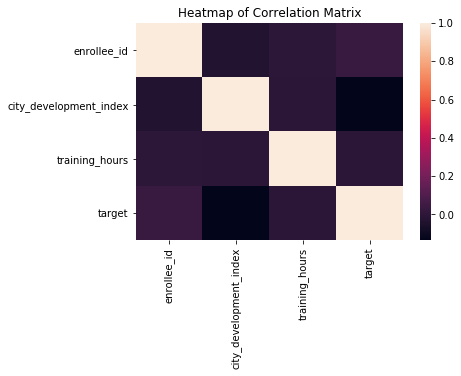

In [10]:
# Create a correlation matrix.
corr = HR_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

### Univariate Analysis

Text(0, 0.5, 'Student Count')

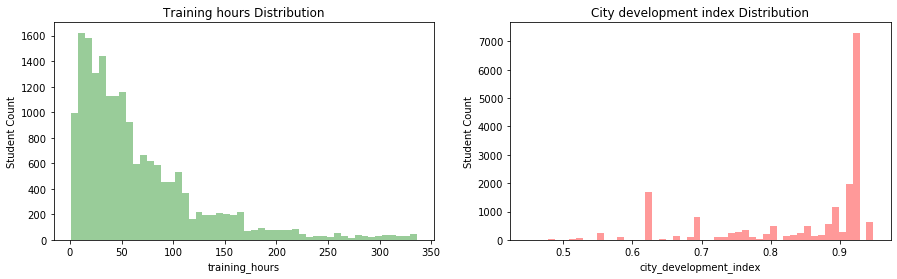

In [11]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Graph Training hours
sns.distplot(HR_train.training_hours, kde=False, color="g", ax=axes[0]).set_title('Training hours Distribution')
axes[0].set_ylabel('Student Count')

# Graph city development index
sns.distplot(HR_train.city_development_index, kde=False, color="r", ax=axes[1]).set_title('City development index Distribution')
axes[1].set_ylabel('Student Count')

Analysis shows that most of the students have done under 100 hours of trainings and more than half of the students are from developed city with city development index greater than 0.9.

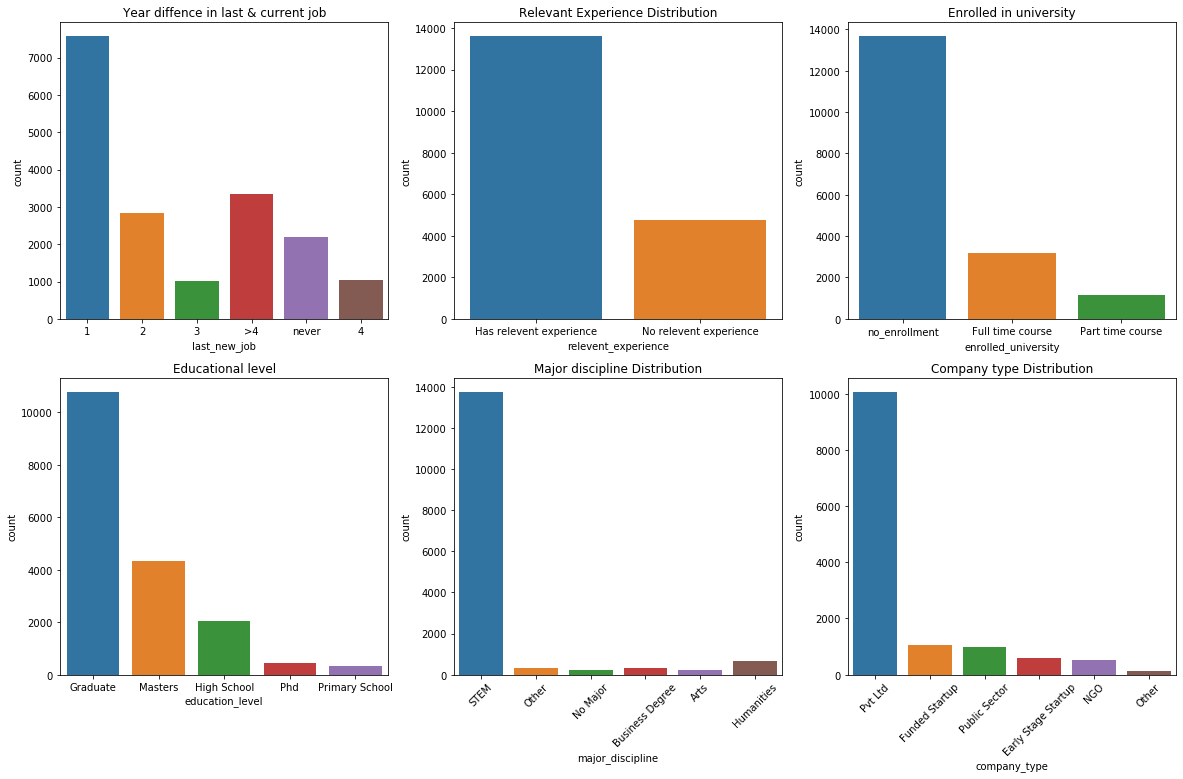

In [12]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3,nrows = 2, figsize=(20, 12))
countPlot(HR_train.last_new_job, 0, 0, 'Year diffence in last & current job')
countPlot(HR_train.relevent_experience, 0, 1, 'Relevant Experience Distribution')
countPlot(HR_train.enrolled_university, 0, 2, 'Enrolled in university')
countPlot(HR_train.education_level, 1, 0, 'Educational level')
countPlot(HR_train.major_discipline, 1, 1, 'Major discipline Distribution', rotation=45)
countPlot(HR_train.company_type, 1, 2, 'Company type Distribution', rotation=45)

- Look like we don't have any outliers in the data for both numerical type as well as discrete variable type.
- Data shows that nearly **40% of the students recently changed the job** i.e. within 1 year period. From this we can say that as industries are transforming more towards analytics, hence the employees are upskilling themselves to stay relevant in the new job by enrolling to this data science course provided by the institute. 

- **70%** of the students have some sort of **prior analytics experience** before joining the course shows that higher level of analytics skills are necessary on the job. Among the students who already has a job, majority are from **private sectors** indicating that private sectors are aggresively leveraging analytics to solve business problems and this skill is in demand in this sector. It may also indicate that their employees are being paid well for this kind of job in comparison with startup, public setors, hence higher level of enrollment coming from private sectors.

- Almost **90% of the students are from STEM** background with very few uniformly distributed across other majors such as Arts, Humanities, Business etc. Among all the students, more than half have a gradudate degree and nearly 20% with a masters degree. 

### Multivariate Analysis
- As we have seen more students are coming from **private sector** companies who had recently changed their job and wanted to upskill themselves even though they have some kind of prior analytics experience. We would see that these cluster of students are also **high** when it comes to **looking for a new job** after the training is over.

- We see that students are **concentrated in either less than 5 years of experience and more than 15 years of experience** group accounting to nearly 60% of the students with nearly **20% have more than 20 years of experience**. They are more likely to switch a job after the course. This suggests that newbies and old people are not that familiar or don't have clear understanding of the emerging technologies although they have some sort of prior experience. They have more tendency to switch as they are working in private sectors or have not started any job yet, suggesting that our initial hypothesis is correct that private sectors are using the emerging technologies aggressively and also ready to pay well for these kind of job.

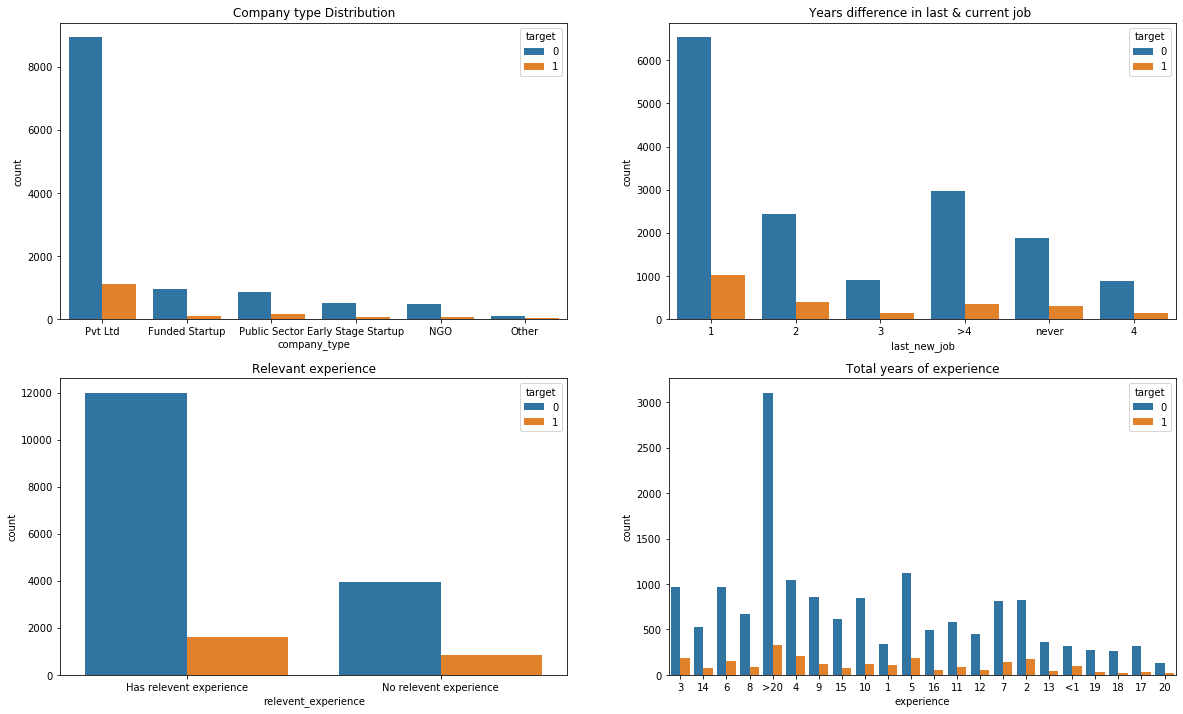

In [13]:
f, axes = plt.subplots(ncols=2,nrows = 2, figsize=(20, 12))
countPlot(HR_train.company_type, 0, 0, 'Company type Distribution', 0,  HR_train.target)
countPlot(HR_train.last_new_job, 0, 1, 'Years difference in last & current job ', 0,  HR_train.target)
countPlot(HR_train.relevent_experience, 1, 0, 'Relevant experience', 0,  HR_train.target)
countPlot(HR_train.experience, 1, 1, 'Total years of experience', 0,  HR_train.target)

In [14]:
print('newbies:', HR_train[HR_train.experience.isin (['1','2','3', '<1', '4', '5'])].shape[0]), 
print('experienced:', HR_train[HR_train.experience.isin (['15','16','17', '18', '19', '20', '>20'])].shape[0])

newbies: 5578
experienced: 5768


- In terms of percentage, we would hypothesize that **people with no relevant experience in analytics will sought a job after the course** as they are wanting to break into data science field by enrolling in the course. From the 1st graph below, we can confirm that more than 15% of the students in this category (has no relevant experience) are looking for a job change (across all majors) with exception to business majors (may be they are being paid well already).
- From the 2nd graph we can see a spike in percentage of students who have neven been employed and belong to 'other' company type category are more likely to look for a job change (or a new job). But we can not conclude this firmly as earlier we saw that very less students belog to this particular category.
- From the first point we concluded that students with **no relevant experience have tendency to look for a new job** in analytics. From graph 3, we can see that it is very likely that major students (above 15%  across all experience level) are looking for a job change after the course.

Text(0.5, 1.0, 'Average percent of students looking for a change grouped by years of experience and relevant experience')

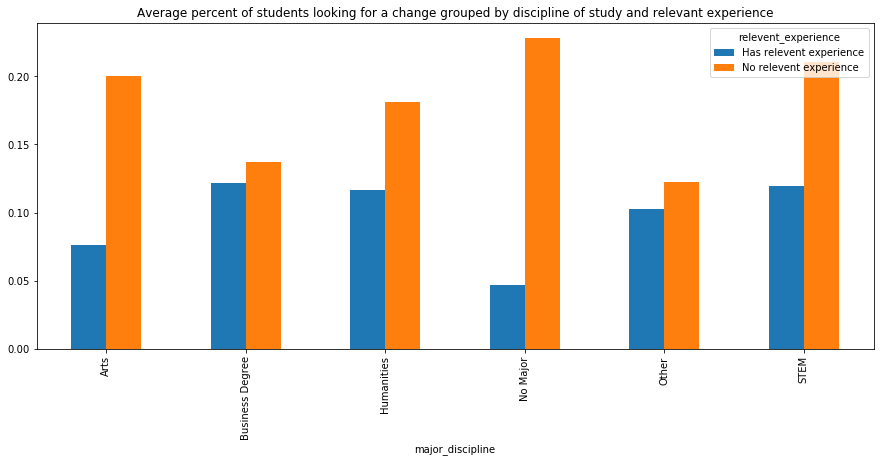

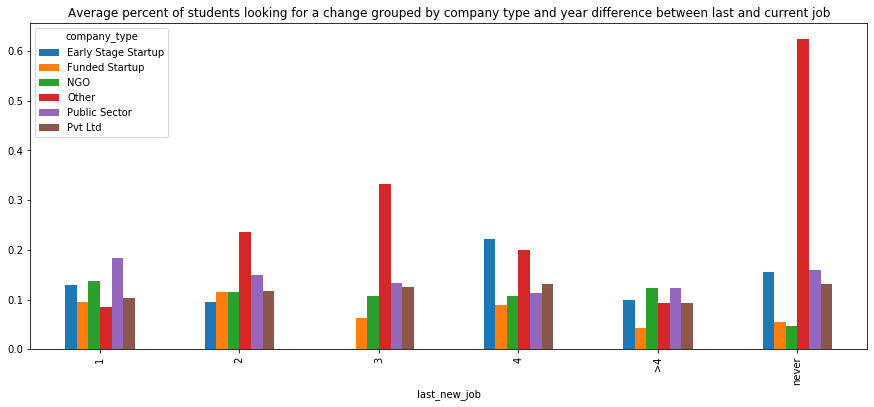

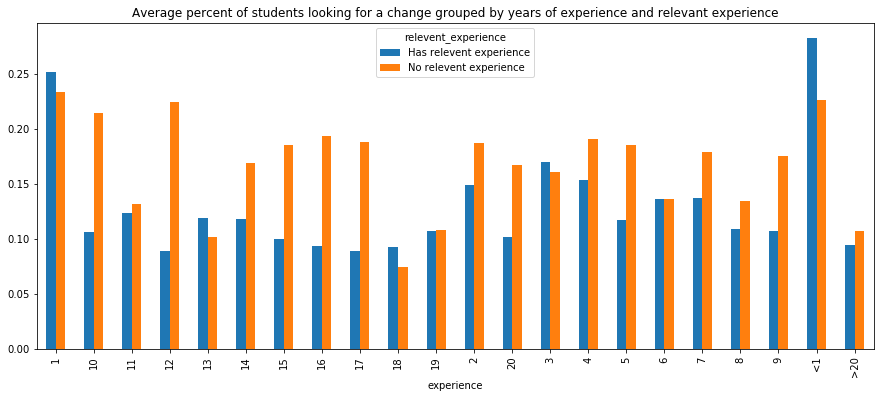

In [15]:
pd.pivot_table(HR_train, values = 'target', index = 'major_discipline', columns = 'relevent_experience',aggfunc ='mean').plot.bar(figsize=(15,6))
plt.title('Average percent of students looking for a change grouped by discipline of study and relevant experience')
pd.pivot_table(HR_train, values = 'target', index = 'last_new_job', columns = 'company_type',aggfunc ='mean').plot.bar(figsize=(15,6))
plt.title('Average percent of students looking for a change grouped by company type and year difference between last and current job')
pd.pivot_table(HR_train, values = 'target', index = 'experience', columns = 'relevent_experience',aggfunc ='mean').plot.bar(figsize=(15,6))
plt.title('Average percent of students looking for a change grouped by years of experience and relevant experience')

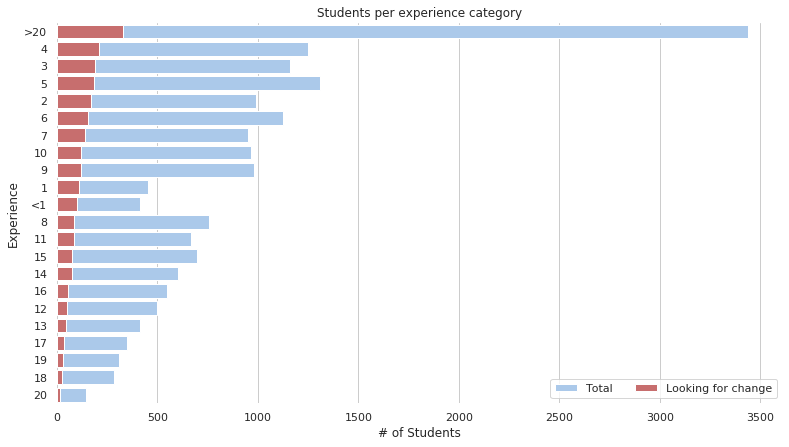

In [16]:
change = HR_train[HR_train['target']==1]
change = pd.DataFrame(change.experience.value_counts()).reset_index()
total = pd.DataFrame(HR_train.experience.value_counts()).reset_index()
merge = pd.merge(change, total, how='inner', on='index')
merge = merge.rename(columns={"experience_x":'change', "experience_y":'total', "index":'experience' })

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))
# plot Total cases by experience
sns.set_color_codes("pastel")
sns.barplot(x="total", y='experience', data=merge,
            label="Total", color="b")
# plot total students who are looking for a change
sns.set_color_codes("muted")
sns.barplot(x="change", y="experience", data=merge,
            label="Looking for change", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Experience", title='Students per experience category',
       xlabel="# of Students")
sns.despine(left=True, bottom=True)

- Interstingly, the analysis shows that **training hours does not make any difference in job outlook** which is not our general conception. We would have thought that people who are being trained more in the institute are the ones who may be looking for a new job, but clearly this is not the case (shown in below graph)

Text(0.5, 1.0, 'Training hours Distribution - Looking for job or not')

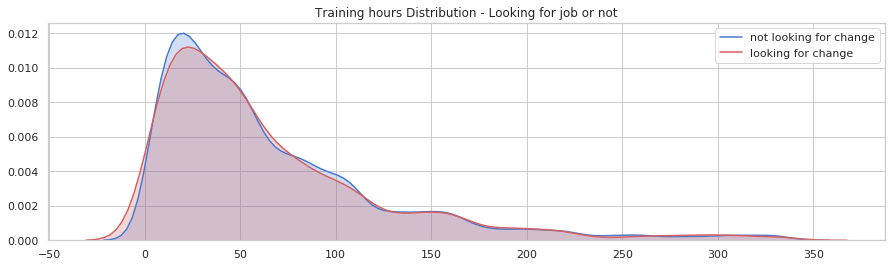

In [17]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(HR_train.loc[(HR_train['target'] == 0),'training_hours'] , color='b',shade=True, label='not looking for change')
ax=sns.kdeplot(HR_train.loc[(HR_train['target'] == 1),'training_hours'] , color='r',shade=True, label='looking for change')
plt.title('Training hours Distribution - Looking for job or not')

### Data Pre-processing steps
we will perform below data pre-processing steps
- Replace missing values in the dataset.
- Necessary data manipulation steps such as converting ordinal and cardinal categorical variables to either numerical or one hot encoded (or level encoded) variables.
- Treating imbalance classes.
- Create a baseline model.

In [18]:
# Replace missing values: We will replace the numerical columns with median and object column with mode.
missing_col = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size',
              'company_type', 'last_new_job']
for col in missing_col:
    fix_missing(HR_train, HR_train[col], col, {})

In [19]:
# Replace ordinal categorical variables with numerics with ordered maintained
experience_mapping = {'Has relevent experience': 2, 'No relevent experience': 1}
enroll_mapping = {'no_enrollment': 1, 'Full time course': 3, 'Part time course': 2}
edu_mapping = {'Graduate': 3, 'Masters': 4, 'High School': 2, 'Phd': 5, 'Primary School': 1}
company_mapping = {'100-500': 4, '<10': 1, '50-99': 3, '5000-9999': 7, '10000+': 8, '1000-4999': 6, '500-999': 5, '10/49': 2}

HR_train['relevent_experience'] = HR_train['relevent_experience'].map(experience_mapping)
HR_train['enrolled_university'] = HR_train['enrolled_university'].map(enroll_mapping)
HR_train['education_level'] = HR_train['education_level'].map(edu_mapping)
HR_train['company_size'] = HR_train['company_size'].map(company_mapping)

# Replace with numbers in experience and last new job variables whenever necessary
HR_train.last_new_job = HR_train.last_new_job.replace({">4": 5, "never": 0}).astype('int')
HR_train.experience = HR_train.experience.replace({"<1": 0, ">20": 21}).astype('int')

In [20]:
# Replace cardinal variables with application of get dummies and rejoin the data after conersion
cat_var = ['company_type','major_discipline','gender','city']
num_var = [var for var in HR_train.columns if var not in cat_var ]
categorical_data = pd.get_dummies(HR_train[cat_var], drop_first=True)
numerical_data = HR_train[num_var]
HR_train = pd.concat([categorical_data,numerical_data], axis=1)
# new_HR_df.head()

### Model development and validation set split

In [21]:
# Remove ID column (not to be used in modelling) and target column
ID = HR_train.enrollee_id
target  = HR_train.target
HR_train = HR_train.drop(['enrollee_id', 'target'], axis = 1)

In [22]:
HR_dev, HR_val, target_dev, target_val = train_test_split(HR_train, target, test_size =0.2, random_state =1, stratify=target)

### Resample Methods for treating imbalance data set
Let's train a base logistic regression model on the three types of samples to see which yields the best result:
1. **Orginal Sample**
2. **Upsampling Data** (adding duplicate rows of minority class and using SMOTE)
3. **Downsampling Data** (delete rows in majority class)

In [23]:
# percentage of each class
target.value_counts()/len(HR_train)*100

0    86.79122
1    13.20878
Name: target, dtype: float64

In [24]:
# Upsample minority class
HR_dev_up, target_dev_up = resample(HR_dev[target_dev == 1],
                                target_dev[target_dev == 1],
                                replace=True,
                                n_samples=HR_dev[target_dev == 0].shape[0],
                                random_state=1)

HR_dev_up = np.concatenate((HR_dev[target_dev == 0], HR_dev_up))
target_dev_up = np.concatenate((target_dev[target_dev == 0], target_dev_up))


# Upsample using SMOTE
sm = SMOTE(random_state=12)
HR_dev_sm, target_dev_sm = sm.fit_sample(HR_dev, target_dev)


# Downsample majority class
HR_dev_dn, target_dev_dn = resample(HR_dev[target_dev == 0],
                                target_dev[target_dev == 0],
                                replace=True,
                                n_samples=HR_dev[target_dev == 1].shape[0],
                                random_state=1)
HR_dev_dn = np.concatenate((HR_dev[target_dev == 1], HR_dev_dn))
target_dev_dn = np.concatenate((target_dev[target_dev == 1], target_dev_dn))


print("Original shape:", HR_dev.shape, target_dev.shape)
print("Upsampled shape:", HR_dev_up.shape, target_dev_up.shape)
print ("SMOTE sample shape:", HR_dev_sm.shape, target_dev_sm.shape)
print("Downsampled shape:", HR_dev_dn.shape, target_dev_dn.shape)

Original shape: (14687, 150) (14687,)
Upsampled shape: (25494, 150) (25494,)
SMOTE sample shape: (25494, 150) (25494,)
Downsampled shape: (3880, 150) (3880,)


### **Apply 10-Fold Cross Validation for Logistic Regression**
#### Train on Original, Upsampled, SMOTE, and Downsampled Data

**Objective**:Train our Logistic Regression Model to our **original, upsampled, and downsampled data** to see which performs best. 

**Resut:**
- **Original Sample**: F1 Score 1%
- **Upsample:** F1 Score 59%
- **SMOTE:** F1 Score 76%
- **Downsample:** F1 Score 59%

**SMOTE gives us the best performance**

**Upsample**

Randomly resample the minority class to create new data.

**SMOTE**

Using the nearest neighbors of the minority observations to create new synthetic data

**Downsample**

By removing some samples of the majority class

In [25]:
# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (HR_dev, target_dev),
                "Upsampled": (HR_dev_up, target_dev_up),
                "SMOTE":(HR_dev_sm, target_dev_sm),
                "Downsampled": (HR_dev_dn, target_dev_dn)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=10, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), HR_dev, target_dev, cv=10, scoring='f1').mean() 

The best F1 Score for Original data:
0.0030560978784329043
The best F1 Score for Upsampled data:
0.5944353443856053
The best F1 Score for SMOTE data:
0.7405123086095962
The best F1 Score for Downsampled data:
0.5952206759292975


0.3073240024080264

### **Metric**: 
We will use AUC metric to evaluate our model

### **Create a Baseline model**

- As we have seen nearly 13% of the students are looking for a new job. Hence, for our baseline model, we will consider this value for all the rows (i.e. each student has 13% chance that he/she is looking for a new job.
- Afterwards, we will check AUC for development data set as well as validation data set. Then we will try to beat this AUC score using robust and better predictive algorithms.

### **Result**

AUC score is 50% for both development data set and validation set.

In [26]:
target_baseline = np.array([0.13])
print('Baseline: AUC of validation set', roc_auc_score(target_val, target_baseline.repeat(len(target_val)))) 
print('Baseline: AUC of development set',roc_auc_score(target_dev, target_baseline.repeat(len(target_dev))))

Baseline: AUC of validation set 0.5
Baseline: AUC of development set 0.5


### **Hypothesize solution**
- Tree methods are best for classification. We will use **logistic regression** along with **randomforest** and **extreme gradient boosting** method 


# 3. Develop
***
### 1. **Logistic regression: AUC score of 52%** 

In [46]:
lr = LogisticRegression()

# Fit the model to the Upsampling data
lr = lr.fit(HR_dev_sm, target_dev_sm)

print ("---Logistic Regression Model---")
lr_auc = roc_auc_score(target_val, lr.predict(HR_val))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

#lr2 = lr.fit(x_train_sm, y_train_sm)
print(classification_report(target_val, lr.predict(HR_val)))

---Logistic Regression Model---
Logistic Regression AUC = 0.52
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3187
           1       0.16      0.21      0.18       485

    accuracy                           0.74      3672
   macro avg       0.52      0.52      0.52      3672
weighted avg       0.78      0.74      0.76      3672



### 2. **Randomforest model  gave AUC 62%**

In [56]:
mdl = RandomForestClassifier(n_jobs=-1)

# Define grid parameters to search for best parameters
param_grid = {
    'min_samples_split': [3, 7,  11],
    'min_samples_leaf' : [3, 7, 11],
    'max_depth'        : [3,  7,  11] 
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score' : make_scorer(roc_auc_score)
}

# Grid search method define
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(mdl, param_grid, scoring=scorers, refit=refit_score,
                           cv=None, return_train_score=True, n_jobs=-1)
    grid_search.fit(HR_dev_sm, target_dev_sm)

    # make the predictions
    y_pred = grid_search.predict(HR_val)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the Validation data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(target_val, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [57]:
# Check for best parameters using refit score as precision score
grid_search_mdl = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 7}

Confusion matrix of Random Forest optimized for precision_score on the Validation data:
     pred_neg  pred_pos
neg      2471       716
pos       296       189


In [58]:
# Train the randomforest model using the best paramets from grid search
mdl = RandomForestClassifier(n_estimators = 800, n_jobs = -1,min_samples_leaf=3,max_features='auto', random_state=11,
                                      criterion='gini',  max_depth = 11, min_samples_split = 7)
mdl.fit(HR_dev_sm, target_dev_sm)
rf_roc_auc = roc_auc_score(target_val, mdl.predict_proba(HR_val)[:,1])
print('RF: AUC of validation set',roc_auc_score(target_val, mdl.predict_proba(HR_val)[:,1]))
print('RF: AUC of development set',roc_auc_score(target_dev_sm, mdl.predict_proba(HR_dev_sm)[:,1]))

RF: AUC of validation set 0.6168820498222483
RF: AUC of development set 0.8772925335374566


### 3. **XGB** classifier model gave AUC of 61% on validation set.

In [31]:
errxgb = []
y_pred_tot_xgb = []

fold = StratifiedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(HR_dev_sm, target_dev_sm):
    x_train, x_val = HR_dev_sm.iloc[train_index], HR_dev_sm.iloc[test_index]
    y_train, y_val = target_dev_sm[train_index], target_dev_sm[test_index]
    m = XGBClassifier(boosting_type='gbdt',
                      max_depth=5,
                      learning_rate=0.05,
                      n_estimators=3000,
                      random_state=194)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=400,
          eval_metric='auc',
          verbose=0)
    pred_y = m.predict_proba(x_val)[:,-1]
    print(i, " err_xgb: ", roc_auc_score(y_val,pred_y))
    errxgb.append(roc_auc_score(y_val,pred_y))
    pred_test = m.predict_proba(HR_val)[:,-1]
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

1  err_xgb:  0.7260425849429611
2  err_xgb:  0.9889823767875137
3  err_xgb:  0.9892127631751014
4  err_xgb:  0.9910069308225448
5  err_xgb:  0.9878130501719071


In [32]:
xgb_auc = roc_auc_score(target_val,  np.mean(y_pred_tot_xgb, 0))
print('XGB: Mean Cross validation AUC score:', np.mean(errxgb,0))
print('XGB: AUC on Validation set:',roc_auc_score(target_val, np.mean(y_pred_tot_xgb, 0)))

XGB: Mean Cross validation AUC score: 0.9366115411800056
XGB: AUC on Validation set: 0.6095060797893505


### ROC graphs

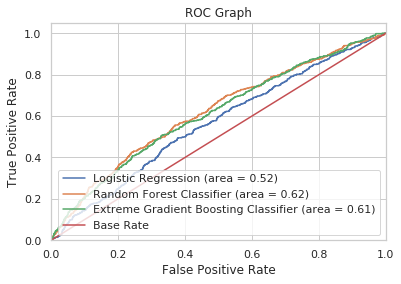

In [33]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(target_val, lr.predict_proba(HR_val)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_val, mdl.predict_proba(HR_val)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(target_val, np.mean(y_pred_tot_xgb, 0))

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot XGB ROC
plt.plot(xgb_fpr, xgb_tpr, label='Extreme Gradient Boosting Classifier (area = %0.2f)' % xgb_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Randomforest feature importance

In [59]:
# Get Feature Importances  (few top features)
feature_importances = pd.DataFrame(mdl.feature_importances_,
                                   index = HR_val.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances[0:12]

,index,importance
0,city_development_index,0.110347
1,company_size_na,0.096900
2,company_type_na,0.093736
3,education_level,0.064651
4,relevent_experience,0.060751
5,gender_na,0.059575
6,city_city_16,0.057506
7,city_city_103,0.042465
8,company_type_Pvt Ltd,0.041261
9,city_city_114,0.035740


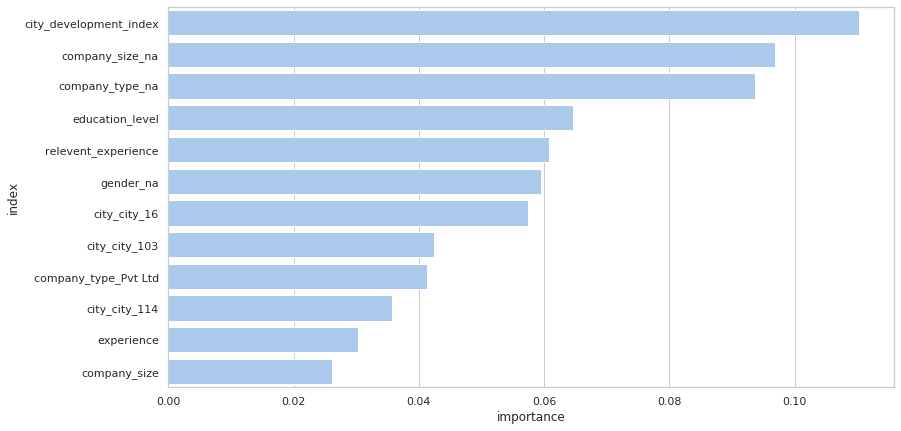

In [60]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance (for first 12 features)
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances[0:12],
            label="Total", color="b")

### Apply random noise to feature importances
After adding a random noise, we check that random noise feature in feature importance table. Probably it's worth mentioning that random noise is not important although it does have some predictive power. City development index has most predictive power along with company size, experience, university enrolled, experience etc.

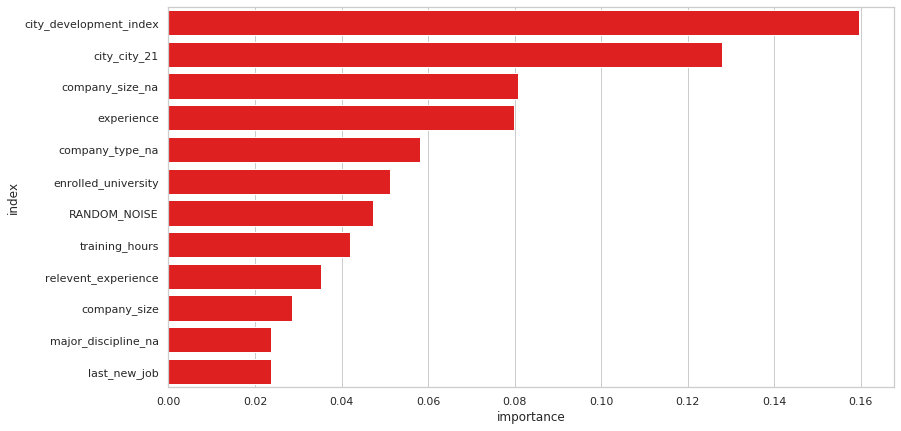

In [55]:
# Apply Random Noise to data set
X_train_rnoise = pd.DataFrame(HR_dev)
X_train_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet
rf_random = RandomForestClassifier(n_estimators = 800, n_jobs = -1,min_samples_leaf=3,max_features='auto', random_state=11,
                                      criterion='gini',  max_depth = 7, min_samples_split = 7)
rf_random = rf_random.fit(X_train_rnoise, target_dev)

# Get Feature Importances
feature_importances_random = pd.DataFrame(rf_random.feature_importances_, index = X_train_rnoise.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

clrs = ['red' ]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random[0:12],
            label="Total",  palette=clrs)

### Best model
We select the **randomforest** model as it gave best AUC score on the validation set.

# 4. Deploy
***
## Automate Training pipeline

In [62]:
class pedict_hr_model:
    # init methods
    def __init__(self, data):
        self.data = data
        
    # replace missing values
    def impute_missing(self):
        missing_col = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size',
              'company_type', 'last_new_job']
        for col in missing_col:
            fix_missing(self.data, self.data[col], col, {})
        return self.data
###############################################################    
def convert_cat_vars(data):
    "Replace ordinal categorical variables with numerics with ordered maintained"
     
    experience_mapping = {'Has relevent experience': 2, 'No relevent experience': 1}
    enroll_mapping = {'no_enrollment': 1, 'Full time course': 3, 'Part time course': 2}
    edu_mapping = {'Graduate': 3, 'Masters': 4, 'High School': 2, 'Phd': 5, 'Primary School': 1}
    company_mapping = {'100-500': 4, '<10': 1, '50-99': 3, '5000-9999': 7, '10000+': 8, '1000-4999': 6, '500-999': 5, '10/49': 2}

    data['relevent_experience'] = data['relevent_experience'].map(experience_mapping)
    data['enrolled_university'] = data['enrolled_university'].map(enroll_mapping)
    data['education_level'] = data['education_level'].map(edu_mapping)
    data['company_size'] = data['company_size'].map(company_mapping)

    "Replace with numbers in experience and last new job variables whenever necessary"
    data['last_new_job'] = data['last_new_job'].replace({">4": 5, "never": 0}).astype('int')
    data['experience'] = data['experience'].replace({"<1": 0, ">20": 21}).astype('int')
    
    "perform get dummies for cardinal variables"
    cat_var = ['company_type','major_discipline','gender','city']
    num_var = [var for var in data.columns if var not in cat_var ]
    categorical_data = pd.get_dummies(data[cat_var], drop_first=True)
    numerical_data = data[num_var]
    data = pd.concat([categorical_data,numerical_data], axis=1)
    return data

def train_model(data):
    "train the model"
    target  = data.target
    data = data.drop(['enrollee_id', 'target'], axis = 1)
    sm = SMOTE(random_state=12)
    HR_sm, target_sm = sm.fit_sample(data, target)
    mdl = RandomForestClassifier(n_estimators = 800, n_jobs = -1,min_samples_leaf=3,max_features='auto', random_state=11,
                                      criterion='gini', max_depth = 11, min_samples_split = 7)
    mdl.fit(data, target)
        # save the model to disk
    pickle.dump(mdl, open('HR_model.sav', 'wb'))

In [63]:
# Read the file, train the model and save
HR_train = pd.read_csv('../input/avhranalytics/train_jqd04QH.csv')
HR_trn = pedict_hr_model(HR_train)
HR_trn = HR_trn.impute_missing()
HR_trn = convert_cat_vars(HR_trn)
train_model(HR_trn)

## Automate prediction pipeline on the new data set

In [64]:
def predict_HR_proba(test):
    "Predict on the new dataset"
    HR_test = pedict_hr_model(test)
    HR_test = HR_test.impute_missing()
    HR_test = convert_cat_vars(HR_test)
    HR_model = pickle.load(open('HR_model.sav', 'rb'))
    enrollee_id = HR_test.enrollee_id
    HR_test = HR_test.drop(['enrollee_id'], axis = 1)
    pred_proba = HR_model.predict_proba(HR_test)[:,1]
    output = pd.DataFrame(enrollee_id)
    output['target'] = pred_proba
    return output

In [65]:
# Read the new data file and predict the probability of job outlook by students
HR_test = pd.read_csv('../input/avhranalytics/test_KaymcHn.csv')
output = predict_HR_proba(HR_test)
output.to_csv('output.csv', index = False)

In [66]:
output.head()

,enrollee_id,target
0,16548,0.403019
1,12036,0.096840
2,11061,0.255552
3,5032,0.094055
4,17599,0.097817


**The testset output from the random forest model gave an AUC score of 68.3% on the private leaderboard (top performer's score was 69.4%)**

## Recommendations & Conclusion
We want our machine learn model to capture as much of the minority class as possible (i.e students looking for job change). Our objective is to catch all of the highly probable students with such characteristics  at the risk of flagging some low-probable students not looking for job change after the course ends. 

May be we can focus on high probable students who may be looking for employment and prepare them and match with right employer.

- Group the incoming students in 3 categories:
   - Not looking for change :Probability of job change less than 0.35
   - Unsure category: probability of job change is between 0.35 and 0.85
   - Highly likely to change job: probability of job change is above 0.85
- Focus on highly likely students to train more to prepare for job interviews. Provide special services to these students  such as mock interviews, additional doubt clarification classes, more rigorous projects related to client industries (with of course for a fee which will generate additional revenue with less resources being used).
- Provide special separate classes (with different tution rate) to students with no prior analytics experience to make them job ready as these are the students mostly are looking for a job change.
- Tie-up with private sector companies so that they can train their employees by sending to this institute with charging corporate rate to these students.
- As private sectors are aggresively using emerging technologies, probably a marketing campaign can be done at these companies. 